In [1]:

from google.colab import files
files.upload()  # Choose your kaggle.json file from your local machine


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ehtishamkhalid57","key":"358f376c62048dd0048f32aedf3b0648"}'}

In [2]:
# STEP 2: Set up Kaggle API and download dataset
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download MovieLens-1M dataset from the given Kaggle URL
!kaggle datasets download -d shikharg97/movielens-1m

# Unzip the downloaded file
!unzip -q movielens-1m.zip


Dataset URL: https://www.kaggle.com/datasets/shikharg97/movielens-1m
License(s): apache-2.0
  0% 0.00/5.65M [00:00<?, ?B/s]
100% 5.65M/5.65M [00:00<00:00, 758MB/s]


In [3]:
# STEP 3: Load the ratings.csv from the unzipped folder
import pandas as pd

ratings = pd.read_csv("ratings.csv")
ratings.head()


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm
import math


In [5]:
# Load MovieLens-1M ratings.csv (ensure it's in your current directory)
ratings = pd.read_csv("ratings.csv")

# Filter to positive interactions only (ratings >= 4)
ratings = ratings[['userId', 'movieId', 'rating']]
ratings = ratings[ratings['rating'] >= 4.0]
ratings['interaction'] = 1

# Encode userId and movieId to consecutive integers
user2idx = {u: i for i, u in enumerate(ratings['userId'].unique())}
item2idx = {i: j for j, i in enumerate(ratings['movieId'].unique())}
ratings['userId'] = ratings['userId'].map(user2idx)
ratings['movieId'] = ratings['movieId'].map(item2idx)

num_users = len(user2idx)
num_items = len(item2idx)


In [19]:
# 1. Split data into train and test sets
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# 2. Define negative sampling function
def negative_sampling(df, num_users, num_items, num_negatives=1):
    user_positive = df.groupby('userId')['movieId'].apply(set).to_dict()
    neg_samples = []

    for user in user_positive:
        positive_items = user_positive[user]
        for _ in range(len(positive_items) * num_negatives):
            negative_item = np.random.randint(num_items)
            while negative_item in positive_items:
                negative_item = np.random.randint(num_items)
            neg_samples.append([user, negative_item, 0])  # 0 = negative label

    neg_df = pd.DataFrame(neg_samples, columns=['userId', 'movieId', 'interaction'])
    pos_df = df[['userId', 'movieId', 'interaction']]
    return pd.concat([pos_df, neg_df], ignore_index=True)

# 3. Apply negative sampling to train set (IMPORTANT: do it BEFORE defining dataset)
train = negative_sampling(train, num_users, num_items)

# 4. Define dataset class
class InteractionDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['userId'].values, dtype=torch.long)
        self.items = torch.tensor(df['movieId'].values, dtype=torch.long)
        self.labels = torch.tensor(df['interaction'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

# 5. Create DataLoader (after negative sampling)
train_dataset = InteractionDataset(train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)



In [20]:
class MLPModel(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.layers = nn.Sequential(
            nn.Linear(emb_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        x = torch.cat([u, i], dim=-1)
        return self.layers(x).squeeze()


In [21]:
class SimulatedCNNModel(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        # Final Linear layer: input = 16 * (2 * emb_dim)
        self.output_layer = nn.Linear(16 * (2 * emb_dim), 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user, item):
        user_vec = self.user_emb(user).unsqueeze(1)  # [batch, 1, emb_dim]
        item_vec = self.item_emb(item).unsqueeze(1)  # [batch, 1, emb_dim]
        x = torch.cat([user_vec, item_vec], dim=1)   # [batch, 2, emb_dim]
        x = x.view(x.size(0), 1, -1)                 # [batch, 1, 2*emb_dim]

        x = self.conv1(x)                            # [batch, 16, 2*emb_dim]
        x = self.relu(x)
        x = x.view(x.size(0), -1)                    # Flatten
        x = self.output_layer(x)
        return self.sigmoid(x).squeeze()


In [22]:
def train_model(model, loader, epochs=5, lr=0.001):
    model.to(device)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for users, items, labels in loader:
            users, items, labels = users.to(device), items.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(users, items)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")
    return model


In [23]:
def recall_at_k(true, pred, k):
    return len(set(pred[:k]) & set(true)) / float(len(true)) if true else 0

def ndcg_at_k(true, pred, k):
    dcg = sum(1 / math.log2(i+2) for i, p in enumerate(pred[:k]) if p in true)
    idcg = sum(1 / math.log2(i+2) for i in range(min(len(true), k)))
    return dcg / idcg if idcg else 0

def evaluate_model(model, test_df, k=10):
    model.eval()
    recalls, ndcgs = [], []
    user_items_train = train.groupby('userId')['movieId'].apply(set).to_dict()
    test_users = test_df['userId'].unique()

    with torch.no_grad():
        for user in tqdm(test_users):
            interacted = user_items_train.get(user, set())
            candidates = list(set(range(num_items)) - interacted)
            if not candidates:
                continue
            users = torch.tensor([user] * len(candidates)).to(device)
            items = torch.tensor(candidates).to(device)
            scores = model(users, items).cpu().numpy()
            top_k = [x for _, x in sorted(zip(scores, candidates), reverse=True)][:k]
            actual = test_df[test_df['userId'] == user]['movieId'].tolist()
            recalls.append(recall_at_k(actual, top_k, k))
            ndcgs.append(ndcg_at_k(actual, top_k, k))
    print(f"Recall@{k}: {np.mean(recalls):.4f}")
    print(f"NDCG@{k}: {np.mean(ndcgs):.4f}")


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp = MLPModel(num_users, num_items)
cnn = SimulatedCNNModel(num_users, num_items)

print("Training MLP...")
mlp = train_model(mlp, train_loader)

print("Training CNN...")
cnn = train_model(cnn, train_loader)

print("Evaluating MLP...")
evaluate_model(mlp, test)

print("Evaluating CNN...")
evaluate_model(cnn, test)


Training MLP...
Epoch 1, Loss: 0.4914
Epoch 2, Loss: 0.4546
Epoch 3, Loss: 0.4462
Epoch 4, Loss: 0.4405
Epoch 5, Loss: 0.4341
Training CNN...
Epoch 1, Loss: 0.4893
Epoch 2, Loss: 0.4596
Epoch 3, Loss: 0.4570
Epoch 4, Loss: 0.4556
Epoch 5, Loss: 0.4545
Evaluating MLP...


100%|██████████| 5995/5995 [01:07<00:00, 88.62it/s]


Recall@10: 0.0702
NDCG@10: 0.1334
Evaluating CNN...


100%|██████████| 5995/5995 [05:11<00:00, 19.27it/s]


Recall@10: 0.0807
NDCG@10: 0.1419


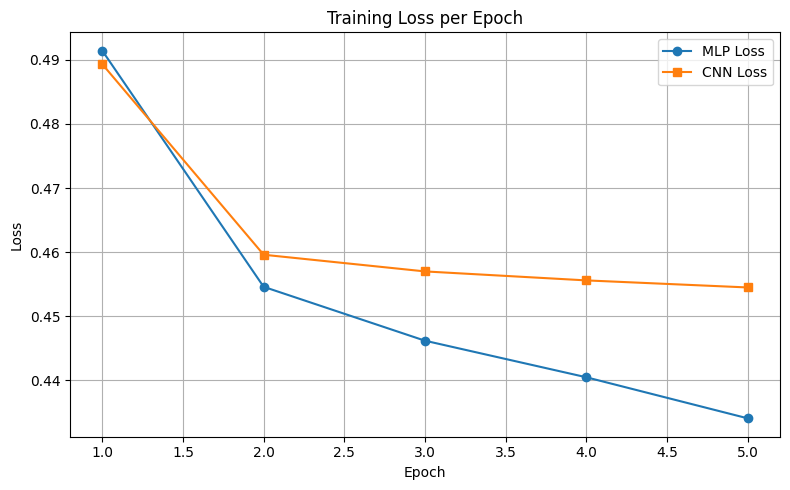

In [25]:
import matplotlib.pyplot as plt

# Loss values per epoch (manually entered from your logs)
mlp_losses = [0.4914, 0.4546, 0.4462, 0.4405, 0.4341]
cnn_losses = [0.4893, 0.4596, 0.4570, 0.4556, 0.4545]
epochs = list(range(1, 6))

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, mlp_losses, marker='o', label='MLP Loss')
plt.plot(epochs, cnn_losses, marker='s', label='CNN Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


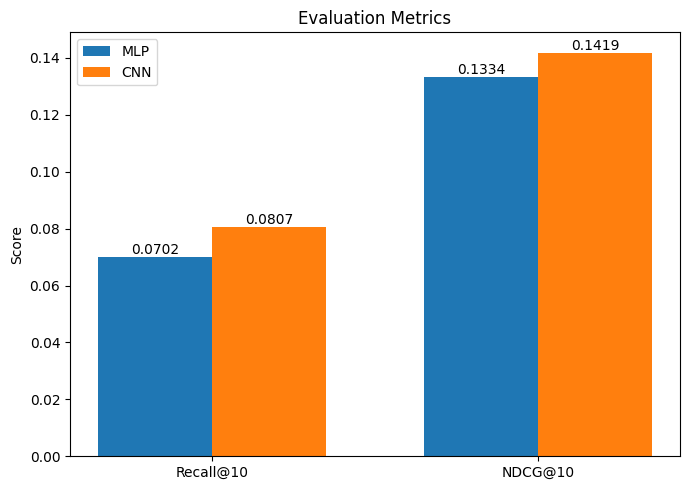

In [26]:
# Recall@10 and NDCG@10
metrics = ['Recall@10', 'NDCG@10']
mlp_scores = [0.0702, 0.1334]
cnn_scores = [0.0807, 0.1419]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))
bars1 = ax.bar(x - width/2, mlp_scores, width, label='MLP')
bars2 = ax.bar(x + width/2, cnn_scores, width, label='CNN')

ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.bar_label(bars1, fmt='%.4f')
ax.bar_label(bars2, fmt='%.4f')
plt.tight_layout()
plt.show()
